## Drone delivery

In [1]:
import gurobipy as gp
import math
from gurobipy import Model, GRB, quicksum, tupledict
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [4]:
# Define the file path
file_path = 'dataset/pdp_100/lr210.txt'

# Read the file lines
with open(file_path, 'r') as file:
    lines = file.readlines()

# First line corresponds to the first DataFrame with number of vehicles, vehicle capacity, and speed
header_data = lines[0].strip().split('\t')
header_df = pd.DataFrame([header_data], columns=["NUMBER OF VEHICLES", "VEHICLE CAPACITY", "SPEED (not used)"])

# The remaining lines correspond to the second DataFrame with task details
task_data = [line.strip().split('\t') for line in lines[1:]]
columns = ["TASK NO.", "X", "Y", "DEMAND", "EARLIEST PICKUP/DELIVERY TIME", 
           "LATEST PICKUP/DELIVERY TIME", "SERVICE TIME", "PICKUP(index to sibling)", "DELIVERY(index to sibling)"]
task_df = pd.DataFrame(task_data, columns=columns)

# Display the dataframes
print("Header DataFrame:")
print(header_df)

print("\nTask Details DataFrame:")
print(task_df)

Header DataFrame:
  NUMBER OF VEHICLES VEHICLE CAPACITY SPEED (not used)
0                 25             1000                1

Task Details DataFrame:
    TASK NO.   X   Y DEMAND EARLIEST PICKUP/DELIVERY TIME  \
0          0  35  35      0                             0   
1          1  41  49     10                           190   
2          2  35  17    -41                            18   
3          3  55  45     -5                           289   
4          4  55  20     19                           679   
..       ...  ..  ..    ...                           ...   
98        98  19  21     10                            21   
99        99  20  26      9                           328   
100      100  18  18    -31                           821   
101      101  53  12     -6                           525   
102      102  15  77     -9                           154   

    LATEST PICKUP/DELIVERY TIME SERVICE TIME PICKUP(index to sibling)  \
0                          1000          

In [5]:
task_df

,TASK NO.,X,Y,DEMAND,EARLIEST PICKUP/DELIVERY TIME,LATEST PICKUP/DELIVERY TIME,SERVICE TIME,PICKUP(index to sibling),DELIVERY(index to sibling)
0,0,35,35,0,0,1000,0,0,0
1,1,41,49,10,190,974,10,0,70
2,2,35,17,-41,18,792,10,85,0
3,3,55,45,-5,289,822,10,42,0
4,4,55,20,19,679,800,10,0,55
...,...,...,...,...,...,...,...,...,...
98,98,19,21,10,21,748,10,0,67
99,99,20,26,9,328,437,10,0,22
100,100,18,18,-31,821,965,10,39,0
101,101,53,12,-6,525,752,10,56,0


In [6]:
task_df = task_df.apply(pd.to_numeric, errors='coerce')

def determine_task_type(row):

    if row["DEMAND"] < 0:
        return "pickup"
    elif row["DEMAND"] > 0:
        return "delivery"
    else:
        return "depot"

task_df['TASK TYPE'] = task_df.apply(determine_task_type, axis=1)


In [7]:
task_df

,TASK NO.,X,Y,DEMAND,EARLIEST PICKUP/DELIVERY TIME,LATEST PICKUP/DELIVERY TIME,SERVICE TIME,PICKUP(index to sibling),DELIVERY(index to sibling),TASK TYPE
0,0,35,35,0,0,1000,0,0,0,depot
1,1,41,49,10,190,974,10,0,70,delivery
2,2,35,17,-41,18,792,10,85,0,pickup
3,3,55,45,-5,289,822,10,42,0,pickup
4,4,55,20,19,679,800,10,0,55,delivery
...,...,...,...,...,...,...,...,...,...,...
98,98,19,21,10,21,748,10,0,67,delivery
99,99,20,26,9,328,437,10,0,22,delivery
100,100,18,18,-31,821,965,10,39,0,pickup
101,101,53,12,-6,525,752,10,56,0,pickup


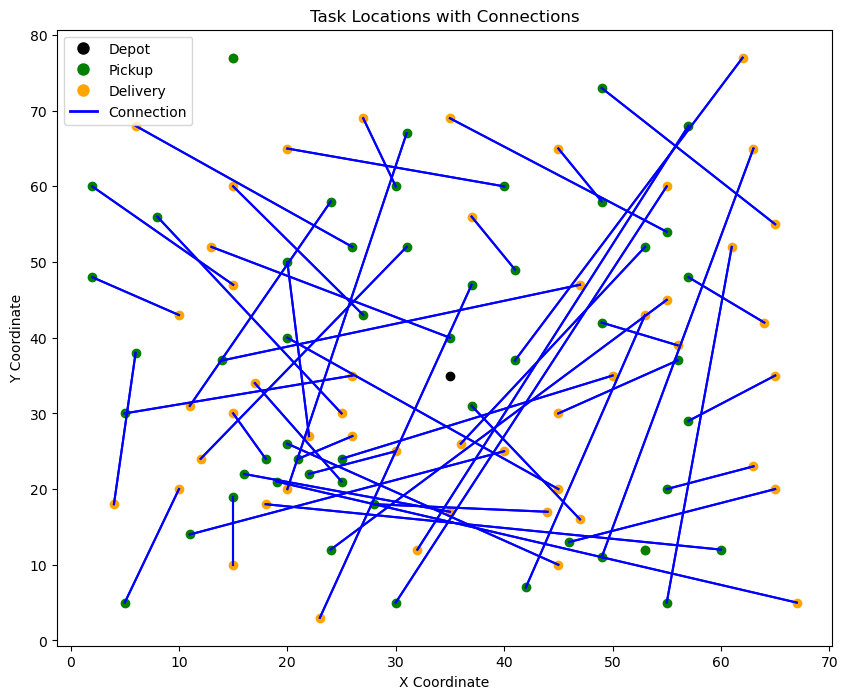

In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Assume task_df has already been created and all columns have been converted to numeric types
# Combine 'PICKUP(index to sibling)' and 'DELIVERY(index to sibling)' into a single 'CONNECTION' column
task_df['CONNECTION'] = task_df[['PICKUP(index to sibling)', 'DELIVERY(index to sibling)']].max(axis=1)
task_df['CONNECTION'] = pd.to_numeric(task_df['CONNECTION'], errors='coerce').fillna(0).astype(int)

# Create the 'photos' folder if it does not exist
os.makedirs('photos', exist_ok=True)

# Create a blank plot
plt.figure(figsize=(10, 8))

# Iterate through each row
for _, row in task_df.iterrows():
    task_type = row['TASK TYPE']
    x, y = row['X'], row['Y']
    
    if task_type == 'depot':
        # Plot depot (black)
        plt.scatter(x, y, color='black')
    
    elif task_type in ['pickup', 'delivery']:
        # Find the corresponding connected task
        sibling_index = row['CONNECTION']
        if sibling_index > 0:
            sibling_row = task_df.iloc[sibling_index]
            sibling_x, sibling_y = sibling_row['X'], sibling_row['Y']
            
            # Plot connected task (green for pickup, orange for delivery)
            plt.scatter(sibling_x, sibling_y, color='green' if task_type == 'pickup' else 'orange')
            
            # Draw connection line (blue)
            plt.plot([x, sibling_x], [y, sibling_y], color='blue')
        else:
            # Plot standalone pickup or delivery task
            plt.scatter(x, y, color='green' if task_type == 'pickup' else 'orange')

# Add legend
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Depot'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Pickup'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Delivery'),
    plt.Line2D([0], [0], color='blue', lw=2, label='Connection')
])

# Set title and labels
plt.title('Task Locations with Connections')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Display the plot
plt.grid(False)
plt.show()


In [9]:
# Create an empty list to store pairing data
pairs = []

# Iterate through each row to find pickups and their corresponding deliveries
for _, row in task_df.iterrows():
    if row['TASK TYPE'] == 'pickup':
        # Find the corresponding delivery task
        sibling_index = row['CONNECTION']
        sibling_row = task_df.iloc[sibling_index]
        
        # Pair the pickup and delivery tasks and store in the list
        pair = {
            'pickup_task': row['TASK NO.'],
            'pickup_x': row['X'],
            'pickup_y': row['Y'],
            'pickup_earliest_time': row['EARLIEST PICKUP/DELIVERY TIME'],
            'pickup_latest_time': row['LATEST PICKUP/DELIVERY TIME'],
            'delivery_task': sibling_row['TASK NO.'],
            'delivery_x': sibling_row['X'],
            'delivery_y': sibling_row['Y'],
            'delivery_earliest_time': sibling_row['EARLIEST PICKUP/DELIVERY TIME'],
            'delivery_latest_time': sibling_row['LATEST PICKUP/DELIVERY TIME']
        }
        pairs.append(pair)

# Convert the list to a DataFrame
pairs_df = pd.DataFrame(pairs)

# Calculate the Euclidean distance between each paired task
pairs_df['distance'] = pairs_df.apply(lambda row: np.sqrt((row['pickup_x'] - row['delivery_x'])**2 +
                                                          (row['pickup_y'] - row['delivery_y'])**2), axis=1)

# Output the paired data
pairs_df


,pickup_task,pickup_x,pickup_y,pickup_earliest_time,pickup_latest_time,delivery_task,delivery_x,delivery_y,delivery_earliest_time,delivery_latest_time,distance
0,2,35,17,18,792,85,16,22,110,727,19.646883
1,3,55,45,289,822,42,24,12,25,292,45.276926
2,5,15,30,20,906,93,18,24,691,969,6.708204
3,6,25,30,355,574,47,8,56,34,602,31.064449
4,8,10,43,393,492,46,2,48,338,805,9.433981
5,9,55,60,394,503,15,30,5,176,299,60.415230
6,11,20,65,206,325,30,40,60,199,414,20.615528
7,12,50,35,15,725,95,25,24,14,793,27.313001
8,13,30,25,694,823,92,22,22,18,159,8.544004
9,14,15,10,32,694,91,15,19,222,964,9.000000


c:\Users\arsju\anaconda3\envs\Gurobi\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


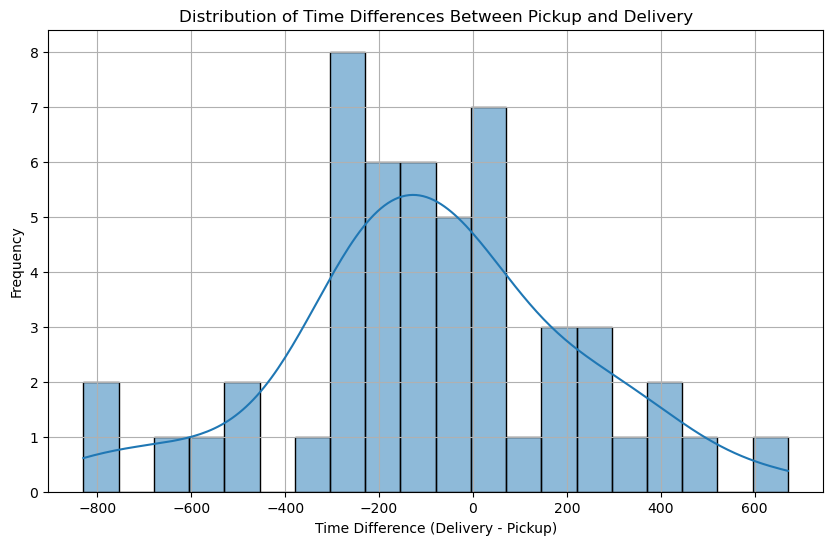

c:\Users\arsju\anaconda3\envs\Gurobi\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


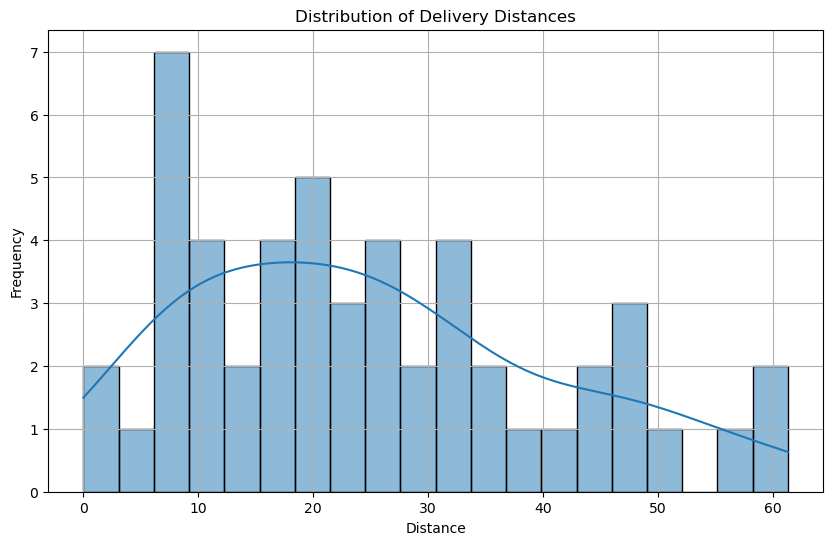

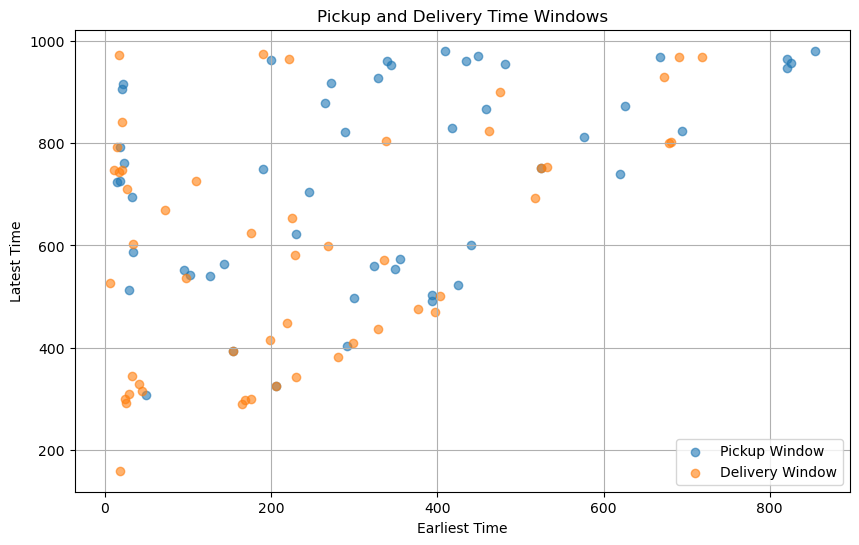

c:\Users\arsju\anaconda3\envs\Gurobi\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


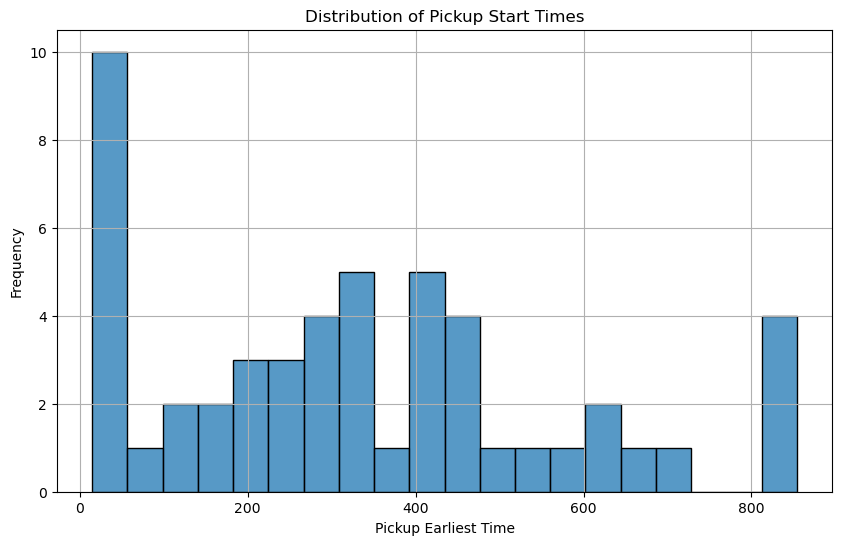

In [10]:
############ Create a list or dictionary to record tasks, sorting by pickup time, with each index corresponding to the earliest pickup point, then go through them one by one
####### Assume there are infinite delivery drones. When there is a pickup task, a drone will be waiting; if no drone is available, add a new one.
############ For the next task, consider delivery. Simply assume each time a pickup starts, there is a drone waiting and ready for delivery.

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calculate the time difference between pickup and delivery
pairs_df['time_difference'] = pairs_df['delivery_earliest_time'] - pairs_df['pickup_earliest_time']

# Plot the distribution of time differences between pickup and delivery
plt.figure(figsize=(10, 6))
sns.histplot(pairs_df['time_difference'], bins=20, kde=True)
plt.title('Distribution of Time Differences Between Pickup and Delivery')
plt.xlabel('Time Difference (Delivery - Pickup)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 2. Plot the distribution of task distances
plt.figure(figsize=(10, 6))
sns.histplot(pairs_df['distance'], bins=20, kde=True)
plt.title('Distribution of Delivery Distances')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 3. Scatter plot of pickup/delivery time windows
plt.figure(figsize=(10, 6))
plt.scatter(pairs_df['pickup_earliest_time'], pairs_df['pickup_latest_time'], label='Pickup Window', alpha=0.6)
plt.scatter(pairs_df['delivery_earliest_time'], pairs_df['delivery_latest_time'], label='Delivery Window', alpha=0.6)
plt.title('Pickup and Delivery Time Windows')
plt.xlabel('Earliest Time')
plt.ylabel('Latest Time')
plt.legend()
plt.grid(True)
plt.show()

# 4. Bar plot of task start times
plt.figure(figsize=(10, 6))
sns.histplot(pairs_df['pickup_earliest_time'], bins=20, kde=False)
plt.title('Distribution of Pickup Start Times')
plt.xlabel('Pickup Earliest Time')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [11]:
import pandas as pd

# Define the bus lines with stations every 10 units
bus_stations = []

# First bus line from (10, 0) to (10, 60) to (70, 60)
for y in range(0, 70, 10):  # Cover (10,0) to (10,60) inclusive
    bus_stations.append({'line': 'Line 1', 'x': float(10), 'y': float(y)})
for x in range(20, 80, 10):  # Cover (10,60) to (70,60) inclusive
    bus_stations.append({'line': 'Line 1', 'x': float(x), 'y': float(60)})

# Second bus line from (0, 20) to (50, 20) to (50, 80)
for x in range(0, 60, 10):  # Cover (0,20) to (50,20) inclusive
    bus_stations.append({'line': 'Line 2', 'x': float(x), 'y': float(20)})
for y in range(30, 90, 10):  # Cover (50,20) to (50,80) inclusive
    bus_stations.append({'line': 'Line 2', 'x': float(50), 'y': float(y)})

# Convert to DataFrame
bus_stations_df = pd.DataFrame(bus_stations)

# Ensure columns 'x' and 'y' are of float type
bus_stations_df['x'] = bus_stations_df['x'].astype(float)
bus_stations_df['y'] = bus_stations_df['y'].astype(float)

# Display the DataFrame
bus_stations_df

,line,x,y
0,Line 1,10.0,0.0
1,Line 1,10.0,10.0
2,Line 1,10.0,20.0
3,Line 1,10.0,30.0
4,Line 1,10.0,40.0
5,Line 1,10.0,50.0
6,Line 1,10.0,60.0
7,Line 1,20.0,60.0
8,Line 1,30.0,60.0
9,Line 1,40.0,60.0


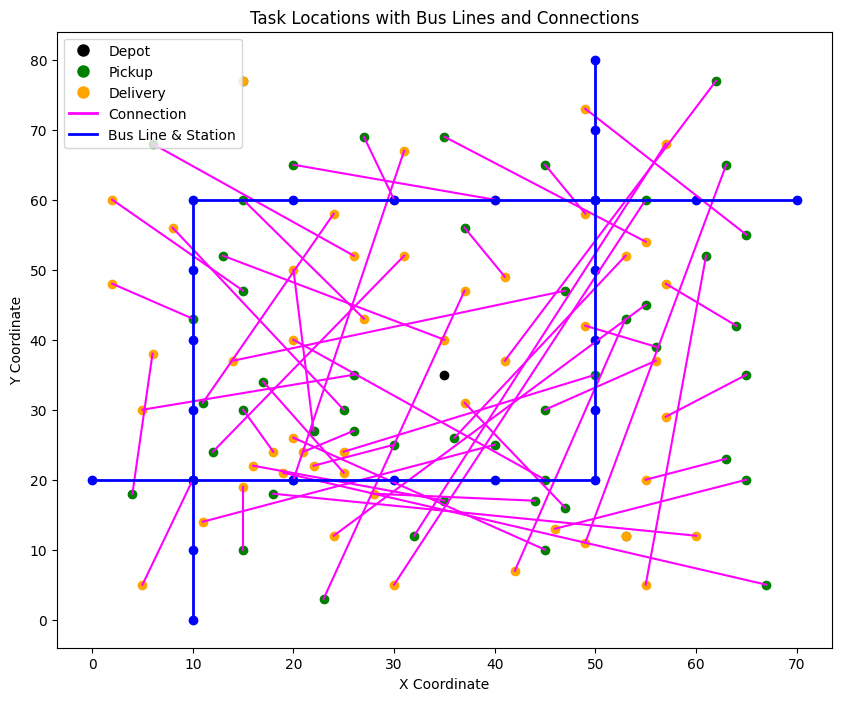

In [271]:
import matplotlib.pyplot as plt

# Existing plot setup for tasks (pickup, delivery, depot)
plt.figure(figsize=(10, 8))

for _, row in task_df.iterrows():
    task_type = row['TASK TYPE']
    x, y = row['X'], row['Y']
    
    if task_type == 'depot':
        plt.scatter(x, y, color='black')
    elif task_type == 'pickup':
        sibling_index = row['CONNECTION']
        sibling_row = task_df.iloc[sibling_index]
        sibling_x, sibling_y = sibling_row['X'], sibling_row['Y']
        plt.scatter(x, y, color='green')
        plt.scatter(sibling_x, sibling_y, color='orange')
        plt.plot([x, sibling_x], [y, sibling_y], color='magenta')
    elif task_type == 'delivery':
        continue  # Already plotted in 'pickup' part

# Plotting the bus stations and lines
for line in bus_stations_df['line'].unique():
    line_stations = bus_stations_df[bus_stations_df['line'] == line]
    
    # Plot bus stations in red
    plt.scatter(line_stations['x'], line_stations['y'], color='blue', label=f'{line} Bus Station')

    # Draw lines connecting bus stations
    plt.plot(line_stations['x'], line_stations['y'], color='blue', linestyle='-', linewidth=2)

# Adding legends
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Depot'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Pickup'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Delivery'),
    plt.Line2D([0], [0], color='magenta', lw=2, label='Connection'),
    plt.Line2D([0], [0], color='blue', lw=2, label='Bus Line & Station')
])

# Set plot title and labels
plt.title('Task Locations with Bus Lines and Connections')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

plt.savefig('photos/lr210.png')

# Display the plot
plt.grid(False)
plt.show()

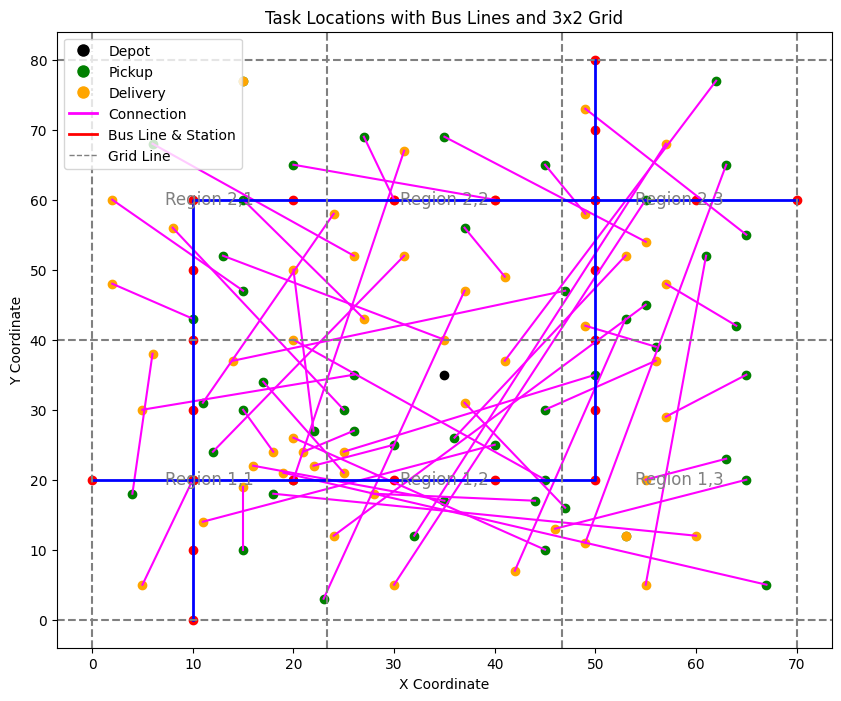

In [ ]:
import numpy as np

# Determine the boundaries of the plot (adjust if necessary based on your plot limits)
x_min, x_max = 0, 70  # Adjust these limits according to the actual size of your plot
y_min, y_max = 0, 80  # Adjust these limits according to the actual size of your plot

# Divide the region into 3 columns and 2 rows
x_intervals = np.linspace(x_min, x_max, 4)  # 3 columns
y_intervals = np.linspace(y_min, y_max, 3)  # 2 rows

# Plot the existing data
plt.figure(figsize=(10, 8))

# Plotting pickup, delivery, and depot points with connections (as in your previous steps)
for _, row in task_df.iterrows():
    task_type = row['TASK TYPE']
    x, y = row['X'], row['Y']
    
    if task_type == 'depot':
        plt.scatter(x, y, color='black')
    elif task_type == 'pickup':
        sibling_index = row['CONNECTION']
        sibling_row = task_df.iloc[sibling_index]
        sibling_x, sibling_y = sibling_row['X'], sibling_row['Y']
        plt.scatter(x, y, color='green')
        plt.scatter(sibling_x, sibling_y, color='orange')
        plt.plot([x, sibling_x], [y, sibling_y], color='magenta')
    elif task_type == 'delivery':
        continue  # Already plotted in 'pickup' part

# Plot bus stations and lines
for line in bus_stations_df['line'].unique():
    line_stations = bus_stations_df[bus_stations_df['line'] == line]
    plt.scatter(line_stations['x'], line_stations['y'], color='red', label=f'{line} Bus Station')
    plt.plot(line_stations['x'], line_stations['y'], color='blue', linestyle='-', linewidth=2)

# Draw the grid lines (3x2 grid)
for x in x_intervals:
    plt.axvline(x=x, color='gray', linestyle='--')  # Vertical lines for columns
for y in y_intervals:
    plt.axhline(y=y, color='gray', linestyle='--')                                                                                # Horizontal lines for rows

# Assigning drones to each region by printing the grid division
for i in range(1, len(x_intervals)):
    for j in range(1, len(y_intervals)):
        # Label the regions
        plt.text((x_intervals[i-1] + x_intervals[i]) / 2,
                 (y_intervals[j-1] + y_intervals[j]) / 2,
                 f'Region {j},{i}', horizontalalignment='center', verticalalignment='center',
                 fontsize=12, color='gray')

# Adding legends
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Depot'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Pickup'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Delivery'),
    plt.Line2D([0], [0], color='magenta', lw=2, label='Connection'),
    plt.Line2D([0], [0], color='red', lw=2, label='Bus Line & Station'),
    plt.Line2D([0], [0], color='gray', lw=1, linestyle='--', label='Grid Line')
])

# Set plot title and labels
plt.title('Task Locations with Bus Lines and 3x2 Grid')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Display the plot
plt.grid(False)
plt.show()

In [12]:
# Assume pairs_df already contains task information and has a 'pickup_earliest_time' column
# Sort tasks by 'pickup_earliest_time' in ascending order
sorted_tasks = pairs_df.sort_values(by='pickup_earliest_time').reset_index(drop=True)

# Create a list or dictionary to store the sorted tasks
task_list = []

# Iterate through the sorted tasks, recording each task's index and details
for index, task in sorted_tasks.iterrows():
    task_record = {
        'index': index,
        'pickup_task': task['pickup_task'],
        'pickup_time': task['pickup_earliest_time'],
        'delivery_task': task['delivery_task'],
        'pickup_x': task['pickup_x'],  # Record pickup_x separately
        'pickup_y': task['pickup_y'],  # Record pickup_y separately
        'delivery_x': task['delivery_x'],  # Record delivery_x separately
        'delivery_y': task['delivery_y'],  # Record delivery_y separately
        'distance': task['distance']
    }
    task_list.append(task_record)

task_list


[{'index': 0,
  'pickup_task': 12.0,
  'pickup_time': 15.0,
  'delivery_task': 95.0,
  'pickup_x': 50.0,
  'pickup_y': 35.0,
  'delivery_x': 25.0,
  'delivery_y': 24.0,
  'distance': 27.313000567495326},
 {'index': 1,
  'pickup_task': 2.0,
  'pickup_time': 18.0,
  'delivery_task': 85.0,
  'pickup_x': 35.0,
  'pickup_y': 17.0,
  'delivery_x': 16.0,
  'delivery_y': 22.0,
  'distance': 19.6468827043885},
 {'index': 2,
  'pickup_task': 21.0,
  'pickup_time': 18.0,
  'delivery_task': 18.0,
  'pickup_x': 45.0,
  'pickup_y': 20.0,
  'delivery_x': 20.0,
  'delivery_y': 40.0,
  'distance': 32.01562118716424},
 {'index': 3,
  'pickup_task': 5.0,
  'pickup_time': 20.0,
  'delivery_task': 93.0,
  'pickup_x': 15.0,
  'pickup_y': 30.0,
  'delivery_x': 18.0,
  'delivery_y': 24.0,
  'distance': 6.708203932499369},
 {'index': 4,
  'pickup_task': 72.0,
  'pickup_time': 22.0,
  'delivery_task': 53.0,
  'pickup_x': 47.0,
  'pickup_y': 16.0,
  'delivery_x': 37.0,
  'delivery_y': 31.0,
  'distance': 18.0277

In [13]:
import numpy as np
from scipy.spatial.distance import cdist
from collections import deque
import math

def find_nearest_bus_station(x, y, bus_stations):
    distances = cdist([(x, y)], [(bs.x, bs.y) for bs in bus_stations])
    nearest_index = np.argmin(distances)
    return bus_stations[nearest_index]

In [14]:
class BusStation:
    def __init__(self, x, y):
        self.x = x
        self.y = y


class Bus:
    def __init__(self, bus_id, route, start_station_index, direction=1, speed=5, stop_time=10):
        """
        Initializes a bus with specified attributes.
        - bus_id: Unique identifier for the bus
        - route: List of stations along the bus route
        - start_station_index: Index of the starting station
        - direction: Travel direction (1 for forward, -1 for reverse)
        - speed: Distance moved per unit time
        - stop_time: Time to wait at each station
        """
        self.bus_id = bus_id
        self.route = route
        self.station_index = start_station_index
        self.direction = direction
        
        # Initialize position using x and y attributes
        self.x = self.route[self.station_index]['x']
        self.y = self.route[self.station_index]['y']
        
        self.speed = speed  # Distance moved per unit time
        self.time_at_station = 0  # Time spent at station
        self.stop_time = stop_time  # Time to stop at each station
        self.status = 'moving'  # Bus status (moving, at_station, etc.)




    def move(self):
        """Defines the movement logic of the bus."""
        if self.status == 'at_station':
            # Bus is waiting at the station
            self.time_at_station += 1
            if self.time_at_station >= self.stop_time:
                # Time to leave the station
                self.status = 'moving'
                self.time_at_station = 0
        else:  # status is 'moving'
            # Bus is moving towards the next station
            next_station_index = self.station_index + self.direction
            if 0 <= next_station_index < len(self.route):
                next_station = self.route[next_station_index]
                # Calculate the Euclidean distance to the next station
                distance_to_next_station = math.sqrt(
                    (self.x - next_station['x']) ** 2 + (self.y - next_station['y']) ** 2
                )

                # Check if bus has reached the next station
                if distance_to_next_station <= self.speed:
                    self.x = next_station['x']
                    self.y = next_station['y']
                    self.station_index += self.direction
                    self.status = 'at_station'
                    # Reverse direction if at route endpoints
                    if self.station_index == 0 or self.station_index == len(self.route) - 1:
                        self.direction *= -1
                else:
                    # Move towards the target proportionally to avoid overshooting
                    move_ratio = self.speed / distance_to_next_station
                    self.x += move_ratio * (next_station['x'] - self.x)
                    self.y += move_ratio * (next_station['y'] - self.y)

In [15]:
class BusSystem:
    def __init__(self, travel_time=30, time_per_station=10):
        self.travel_time = travel_time  # Base time for each transport
        self.time_per_station = time_per_station  # Additional time for each bus station passed
        self.tasks_transported = 0  # Tracks the number of bus transports
        self.buses = []  # List of buses
        self.bus_id_counter = 0  # Used to assign a unique ID to each bus
        self.time = 0  # Global system time

    def initialize_buses(self, bus_lines, bus_stations_df):
        """Initialize buses for each line, adding new buses each time it's called"""
        for line in bus_lines:
            route_stations = [station for station in bus_stations_df.to_dict('records') if station['line'] == line]
            # Add new buses for this line
            self.buses.append(Bus(self.bus_id_counter, route_stations, 0, direction=1))
            self.bus_id_counter += 1
            self.buses.append(Bus(self.bus_id_counter, route_stations, len(route_stations) - 1, direction=-1))
            self.bus_id_counter += 1

    def update_buses(self):
        """Update the position of all buses"""
        for bus in self.buses:
            bus.move()
            # print(f"Bus {bus.bus_id} at ({bus.x}, {bus.y}), Status: {bus.status}, Direction: {bus.direction}")

    def simulate(self, bus_lines, bus_stations_df):
        """Dispatch a bus every 50 time units and update the positions of all buses"""
        # Add new buses every 50 time units
        if self.time % 50 == 0:
            # print(f"Starting new buses on all lines at time {self.time}.")
            self.initialize_buses(bus_lines, bus_stations_df)

        # Update the positions of all buses
        self.update_buses()
        self.time += 1  # Increment time step

    def check_buses_at_station_for_pickup(self, x, y, tolerance=0.1):
        """Check if there is a bus at a station for pickup (allows a certain tolerance to avoid floating-point errors).
        This function does not require a bus ID.
        """
        for bus in self.buses:
            # Check if the bus is at the specified location (using tolerance)
            if math.isclose(bus.x, x, abs_tol=tolerance) and math.isclose(bus.y, y, abs_tol=tolerance):
                # print(f"Bus {bus.bus_id} found at station ({x}, {y}), Status: {bus.status}")
                return bus
        # print(f"No bus found at station ({x}, {y}) for pickup.")
        return None

    def check_buses_at_station_for_delivery(self, x, y, bus_id, tolerance=0.1):
        """Check if a specified bus (by ID) is at a station for delivery (allows a certain tolerance to avoid floating-point errors).
        This function requires a bus ID.
        """
        for bus in self.buses:
            # Check if the bus location and ID match
            if (math.isclose(bus.x, x, abs_tol=tolerance) and 
                math.isclose(bus.y, y, abs_tol=tolerance) and 
                bus.bus_id == bus_id):
                # print(f"Bus {bus.bus_id} found at station ({x}, {y}) for delivery.")
                return bus
        # print(f"No matching bus found at station ({x}, {y}) for delivery with bus_id: {bus_id}")
        return None


In [16]:
# Store records for each time step
simulation_records = []

bus_stations = [BusStation(row['x'], row['y']) for index, row in bus_stations_df.iterrows()]

# Initialize bus lines
bus_lines = ['Line 1', 'Line 2']
bus_system = BusSystem()
bus_system.simulate(bus_lines, bus_stations_df)

# We have a task list, tasks is sorted by pickup_time
tasks = task_list
# Initialize status for each task
for task in tasks:
    task['pickup_status'] = 'unassigned'  # Pickup task status
    task['delivery_status'] = 'unassigned'  # Delivery task status

# Omitted: Other initializations and simulation